<a href="https://colab.research.google.com/github/bayashi-cl/statistical-learning/blob/main/note/03_LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from math import sqrt

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import pandas as pd
import seaborn as sns
import numpy as np
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
import plotly.express as px

sns.set()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
ad = pd.read_csv("https://www.statlearning.com/s/Advertising.csv", index_col=0)

In [3]:
X = ad['TV'].to_numpy()
Y = ad['sales'].to_numpy()
x_bar = X.mean()
y_bar = Y.mean()
n = len(X)

# 3 線形回帰

線形回帰の特徴
* 教師あり学習
* シンプル
* 定量的な予測に強い

今後に出てくる学習の手法は線形回帰を発展させたものが多い。

`Advertising`のデータからマーケティングプランを提案するにはどのような情報が必要だろうか。

以下のような問題について考える。

1. そもそも広告費と売上の間に関係性はあるか。
1. その関係はどれくらい強いのか。
1. どのメディアがどれだけ売上に貢献しているか。
1. 売上の予測はどれくらい正確か。
1. 関係性は線形か。
1. メディア間の相乗効果は存在するのか。



## 3.1 単回帰

単回帰では $Y$ を目的変数、 $X$ を説明変数として、

$$Y \approx \beta_0 + \beta_1X$$

のようなモデルを考える。例えば`sales`と`TV`の関係なら、

$$\textrm{sales} \approx \beta_0 + \beta_1 \times \textrm{TV}$$

として $\hat{\beta}$ を求める。


### 3.1.1 パラメータの推定

まずは**最小二乗法**で考える（他の考え方は6章で）。

$\hat{y}_i = \hat{\beta_0}+\hat{\beta_1}x_i$ を $i$ 番目のデータに対する推定値として残差を $e_i = y_i - \hat{y_i}$ とする。

ここで**残差平方和**(*residual sum of squares (RSS)*)を

$$\textrm{RSS} = e_1^2+ \cdots + e_n^2$$

と定義してこれを最小化すると、

$$
\begin{aligned}
  \hat{\beta_1} &= \frac{\sum_{i=1}^n(x_i-\bar{x})(y_i-\bar{y})}{\sum_{i=1}^n(x_i-\bar{x})^2}\\
  \hat{\beta_0} &= \bar{y}-\hat{\beta_1}\bar{x}
\end{aligned}
$$

となる。

実際に計算をする

In [4]:
numerator = 0.0
denominator = 0.0

for xi, yi in zip(X, Y):
  numerator += (xi - x_bar) * (yi - y_bar)
  denominator += (xi - x_bar)**2

beta_hat_1 = numerator / denominator
beta_hat_0 = y_bar - beta_hat_1 * x_bar

min_rss = 0.0
for xi, yi in zip(X, Y):
  yi_hat = beta_hat_0 + beta_hat_1 * xi
  min_rss += (yi - yi_hat)**2


print(f"sales   = {beta_hat_0:.5f} + {beta_hat_1:.5f} * TV")
print(f"min RSS = {min_rss:.5f}")

sales   = 7.03259 + 0.04754 * TV
min RSS = 2102.53058


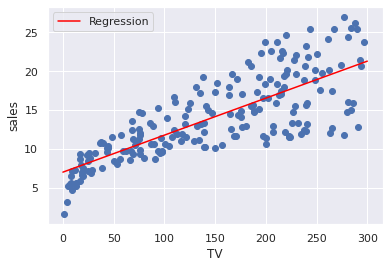

In [5]:
fig, ax = plt.subplots()
ax.scatter(ad['TV'], ad['sales'])
reg_x = np.linspace(0, 300, 100)
reg_y = beta_hat_0 + beta_hat_1 * reg_x
ax.plot(reg_x, reg_y, color="red", label="Regression")
ax.set(xlabel="TV", ylabel="sales")
ax.legend()
plt.show()

In [6]:
sz = 50
b0_ = np.linspace(beta_hat_0 - 2, beta_hat_0 + 2, sz)
b1_ = np.linspace(beta_hat_1 - 0.02, beta_hat_1 + 0.02, sz)
b0, b1 = np.meshgrid(b0_, b1_, indexing='xy')
rss = np.zeros((sz, sz))

for (i, j), _ in np.ndenumerate(rss):
    rss[i, j] = ((Y - (b0[i, j] + X * b1[i, j]))**2).sum()

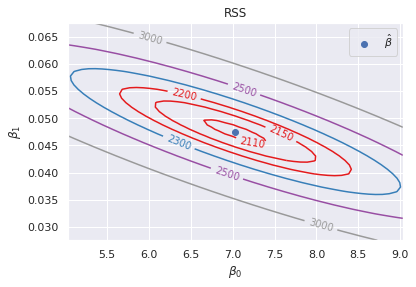

In [7]:
fig, ax = plt.subplots()
cont = ax.contour(b0, b1, rss, cmap=plt.cm.Set1, levels=[2110, 2150, 2200, 2300, 2500, 3000])
cont.clabel(fmt='%1.0f', fontsize=10)
ax.scatter(beta_hat_0, beta_hat_1, label=r"$\hat{\beta}$")
ax.set(xlabel=r"$\beta_0$", ylabel=r"$\beta_1$", title="RSS")
ax.legend()
plt.show()

### 3.1.2 推定値の制度の評価

母集団に対してこのモデルをあてはめると $X$ と $Y$の関係は

$Y = \beta_0 + \beta_1X + \epsilon$

この式は**母集団回帰線** *(population regression line)* と呼ばれ、誤差項 $\epsilon$ はこのモデルで見逃している要素（他の変数や観測誤差など）を表す。

最小二乗法による推定は母集団回帰線に一致するとは限らないが、不偏性があるので観測を繰り返せば正確になっていく。

$\hat{\beta_0}$ と $\hat{\beta_1}$ の分散はそれぞれ、

$$
\textrm{SE}(\hat{\beta_0})^2 = \sigma^2\left[ \frac{1}{n}+\frac{\bar{x}^2}{\sum_{i=1}^n(x_i-\bar{x})^2}\right]
$$

$$
\textrm{SE}(\hat{\beta_1})^2 = \frac{\sigma^2}{\sum_{i=1}^n(x_i-\bar{x})^2}
$$

厳密には誤差 $\epsilon$ が共通の分散を持ち無相関である必要があるが、そうでなくても近似として有効である。

$x$がバラけていたほうが$\hat{\beta_1}$ の分散が小さくなり、少ないデータで正確な推定ができるようになる。

$\sigma^2$ は未知だが、データから推定することができ、その推定量 $\textrm{RSE} = \sqrt{\textrm{RSS}/(n-2)}$ を**残差標準偏差** *(residual standard error)* と呼ぶ 

標準偏差は信頼区間の推定にも使うことができ、その95%信頼区間はそれぞれ

$$\hat{\beta_1} \pm 2 \cdot \textrm{SE}(\hat{\beta_1})$$
$$\hat{\beta_0} \pm 2 \cdot \textrm{SE}(\hat{\beta_0})$$

で構成される。


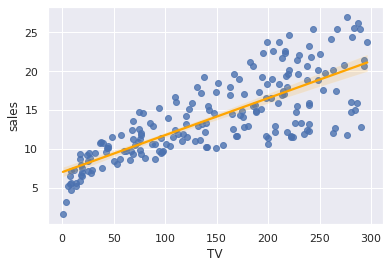

In [8]:
sns.regplot(data=ad, x="TV", y="sales", line_kws={'color': 'orange'})
plt.show()

$X$ と $Y$ に関係性があるかは次の検定により確認できる。

$$
H_0:\beta_1 = 0\\
H_1:\beta_1 \ne 0
$$

t統計量が標準偏差のばらつきを無視できるほど大きければ帰無仮説をrejectできる。

In [9]:
model_TV = ols(formula='sales ~ TV', data=ad).fit()
model_newspaper = ols(formula='sales ~ newspaper', data=ad).fit()

In [10]:
print(model_TV.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.610    
Dependent Variable: sales            AIC:                1042.0913
Date:               2021-12-20 05:50 BIC:                1048.6880
No. Observations:   200              Log-Likelihood:     -519.05  
Df Model:           1                F-statistic:        312.1    
Df Residuals:       198              Prob (F-statistic): 1.47e-42 
R-squared:          0.612            Scale:              10.619   
--------------------------------------------------------------------
              Coef.    Std.Err.      t      P>|t|    [0.025   0.975]
--------------------------------------------------------------------
Intercept     7.0326     0.4578   15.3603   0.0000   6.1297   7.9355
TV            0.0475     0.0027   17.6676   0.0000   0.0422   0.0528
------------------------------------------------------------------
Omnibus:              0.531         Durbin-Watson:           1.935
Pro

### 3.1.3 モデルの精度を評価する

モデルがデータにどれくらいフィットしているかを知りたい。

通常、**$R^2$統計量**と**残差標準誤差** *residual standard error (RSE)* で評価される。

#### 残差標準誤差

大雑把に言うと、RSEと真の回帰直線から予測値が平均してどれだけ離れているかを表す数値であり、次の式で表される。

$$\textrm{RSE} = \sqrt{\frac{1}{n-2}\textrm{RSS}}$$


In [11]:
rse = sqrt(1 / (n - 2) * min_rss)
print(f"RSE = {rse:.5f}")

RSE = 3.25866


#### $R^2$統計量

RSEは単位が $Y$ に依存するのでそれによらない統計量が欲しい。

$$R^2 = \frac{\textrm{TSS}-\textrm{RSS}}{\textrm{TSS}} = 1-\frac{\textrm{RSS}}{\textrm{TSS}}$$

ここで、$\textrm{TSS}=\sum(y_i-\bar{y})^2$ は**全平方和** *(total sum of squares)*

RSSが回帰を行った後の予測のばらつきを表すのに対して、TSSは回帰を行う前のばらつきを表す。よって $R^2$ 統計量は回帰によりどれだけのばらつきが除去されたかを表し、1に近いほどより多くの要素が回帰によって説明されたことになる。

単回帰の場合は$R^2$統計量は相関係数の2乗と一致するが、次の重回帰では有用である。

In [12]:
corr2 = np.corrcoef(X, Y)[1, 0]**2
print(f"corr^2 = {corr2:.5f}")

corr^2 = 0.61188


## 3.2 重回帰

単回帰を拡張し、次のようなモデルを考える。

$$Y = \beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p + \epsilon$$

`Advertising`の例では次のようになる。

$$\textrm{sales} = \beta_0 + \beta_1\times\textrm{TV} + \beta_2\times\textrm{radio} + \beta_3\times\textrm{newspaper} + \epsilon$$



In [13]:
model_TV_radio= ols(formula='sales ~ TV + radio', data=ad).fit()
model_TV_radio_newspaper= ols(formula='sales ~ TV + radio + newspaper', data=ad).fit()

### 3.2.1 回帰係数の推定

単回帰の場合を自然に拡張して推定が可能。

得られる係数は他の要素を固定した状態での変化量。

In [14]:
print(model_TV_radio_newspaper.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.896   
Dependent Variable: sales            AIC:                780.3622
Date:               2021-12-20 05:50 BIC:                793.5555
No. Observations:   200              Log-Likelihood:     -386.18 
Df Model:           3                F-statistic:        570.3   
Df Residuals:       196              Prob (F-statistic): 1.58e-96
R-squared:          0.897            Scale:              2.8409  
------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025  0.975]
------------------------------------------------------------------
Intercept       2.9389    0.3119   9.4223  0.0000   2.3238  3.5540
TV              0.0458    0.0014  32.8086  0.0000   0.0430  0.0485
radio           0.1885    0.0086  21.8935  0.0000   0.1715  0.2055
newspaper      -0.0010    0.0059  -0.1767  0.8599  -0.0126  0.0105
--------------------

In [15]:
print(model_TV_radio.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.896   
Dependent Variable: sales            AIC:                778.3941
Date:               2021-12-20 05:50 BIC:                788.2891
No. Observations:   200              Log-Likelihood:     -386.20 
Df Model:           2                F-statistic:        859.6   
Df Residuals:       197              Prob (F-statistic): 4.83e-98
R-squared:          0.897            Scale:              2.8270  
-------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|    [0.025   0.975]
-------------------------------------------------------------------
Intercept    2.9211     0.2945    9.9192   0.0000   2.3403   3.5019
TV           0.0458     0.0014   32.9087   0.0000   0.0430   0.0485
radio        0.1880     0.0080   23.3824   0.0000   0.1721   0.2038
-----------------------------------------------------------------
Omnibus:       

In [16]:
print(model_newspaper.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.047    
Dependent Variable: sales            AIC:                1220.6714
Date:               2021-12-20 05:50 BIC:                1227.2680
No. Observations:   200              Log-Likelihood:     -608.34  
Df Model:           1                F-statistic:        10.89    
Df Residuals:       198              Prob (F-statistic): 0.00115  
R-squared:          0.052            Scale:              25.933   
-------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
-------------------------------------------------------------------
Intercept      12.3514    0.6214  19.8761  0.0000  11.1260  13.5769
newspaper       0.0547    0.0166   3.2996  0.0011   0.0220   0.0874
------------------------------------------------------------------
Omnibus:               6.231        Durbin-Watson:           1.983
Prob(Omn

In [17]:
ad.corr()

,TV,radio,newspaper,sales
TV,1.000000,0.054809,0.056648,0.782224
radio,0.054809,1.000000,0.354104,0.576223
newspaper,0.056648,0.354104,1.000000,0.228299
sales,0.782224,0.576223,0.228299,1.000000


`newspaper`に注目すると、単回帰では売上との関係が認められるが、重回帰では認められないという結果になっている。重回帰による結果が正しいと仮定し`radio`と`newspaper`の相関係数が大きいことに注目すると、`radio`が大きいと`sales`も`newspaper`も大きくなるという疑似相関が見えてくる。

### 3.2.2 いくつかの重要な疑問

1. 説明変数 $X_1, X_2, \ldots, X_p$のうち有用なものは存在するのか。
1. すべての予測変数がYを説明するのに役立つか，一部の予測変数だけが有用なのか
1. モデルはどのくらいデータに適合しているか？
1. 説明変数のセットが与えられた場合、どのような推定をすべきか。そして、その推定はどのくらい正確か。



#### 1 説明変数と推定値に関係はあるか

以下の検定を考える

$H_0:\beta_1 = \cdots = \beta_p = 0$ v.s. $H_1:$ 少なくとも1つの $\beta_j$ が非ゼロ

f統計量を使う。

$$F = \frac{(\textrm{TSS}-\textrm{RSS})/p}{\textrm{RSS}/(n-p-1)}$$

帰無仮説が正しければ $E[(\textrm{TSS}-\textrm{RSS})/p] = \sigma^2$ となり、$F$ は1に近い値になる。一方、対立仮説が正しければ $E[\textrm{RSS}/(n-p-1)] = \sigma^2$ となり、 $E[(\textrm{TSS}-\textrm{RSS})/p] > \sigma^2$ となるため、$F$ は1よりも大きい値になる。

棄却域は $n$ と $p$ に依存する。詳しくは現代数理統計学の11.3節へ

`Advertising`ではF統計量が1よりも非常に大きいことから、少なくとも1つのメディアが売上増加と関連しているという極めて強い証拠が得られる。

説明変数が多いとp値を個別に見ただけではそれが偶然小さい値をとっているだけの可能性があるが、F統計量は説明変数の数を調整しているため、そのような問題が発生しない。

$p>n$ の場合にはそもそも最小二乗法が使えないため、前方選択や6章に出てくる手法を使うことになる。

#### 2 どの変数が重要か

大抵の場合、全ての説明変数が目的変数に関係しているわけではない。理想的には全てのモデルを作り、比較することで **変数選択** を行う必要がある。比較の際に基準となる統計情報については
* 赤池情報量基準(AIC)
* ベイズ情報量基準(BIC)
* adjusted $R^2$

などがある。 

しかし、この方法では $2^p$ 個のモデルを作ることになり、嬉しくない。よって効率化が必要である。

古典的には以下のような手法がある。

##### 前方選択
切片のみの状態から、単回帰を行いRSSが小さい順に変数を貪欲に追加していく。余分な変数を含んでしまうことがある。

##### 後方選択
全ての変数が選択された状態からp値が大きい順に除去していく。$p>n$ のときは使えない。

##### 混合選択
前方選択を行い、p値が一定値を上回った場合にその変数を除去する。


##### 3 モデルの適合度

単回帰のときと同じようにRSEと$R^2$を使う

重回帰の場合、 $R^2 = \textrm{Cor}(Y, \hat{Y})^2$ となる。

$R^2$の値が1に近いとき、そのモデルが分散の大部分を説明できていることになる。

`TV`と`radio`のモデルと`TV`と`radio`と`newspaper`のモデルを比較すると、 $R^2$ がほとんど変化していない（実際には微増）ことから、過学習が発生している可能性があり、`newspaper`が除外できる事がわかる。


In [18]:
def calc_rse(model, Y_, data):
  y_hat = model.predict(data)
  p = len(model.params) - 1
  n = len(data)
  return sqrt(1 / (n - p - 1) * ((Y_ - y_hat)**2).sum())

In [19]:
rse_TV = calc_rse(model_TV, Y, ad)
rse_TV_radio = calc_rse(model_TV_radio, Y, ad)
rse_multi = calc_rse(model_TV_radio_newspaper, Y, ad)
print(f"RSE TV                     = {rse_TV:.5f}")
print(f"RSE TV & radio             = {rse_TV_radio:.5f}")
print(f"RSE TV & radio & newspaper = {rse_multi:.5f}")

RSE TV                     = 3.25866
RSE TV & radio             = 1.68136
RSE TV & radio & newspaper = 1.68551


`TV`から`TV & radio`ではRSEが減少しているのに対して`TV & radio`から`TV & radio & newspaper`ではRSEが増加している。これは重回帰のRSEが

$$\textrm{RSE} = \sqrt{\frac{1}{n-p-1}\textrm{RSS}}$$

と表されるためである。

In [20]:
error = Y - model_TV_radio.predict(ad)
fig = px.scatter_3d(ad, x='TV', y='radio', z='sales', color=error)
fig.update_traces(marker_size=2)
fig.show()

グラフからわかるようにこのデータは線形ではなく2つのメディアを利用すると相乗効果がありそう。

3.3.2ではこのようなことを考慮に入れる。

##### 予測

予測にあたってモデルの式をそのまま使うと3つの不確実性が生じる。

1. 推定値は真の値とは異なる　-> 信頼区間を考える
1. 線形モデルは現実の（線形でない）モデルの表面を近似しているに過ぎない。 -> 無視
1. 真の$\beta$がわかったとしても $\epsilon$ による誤差が存在する。 -> 区間で予測する。




In [21]:
credit = pd.read_csv("https://www.statlearning.com/s/Credit.csv")
credit.head()

,Income,Limit,Rating,Cards,Age,Education,Own,Student,Married,Region,Balance
0,14.891,3606,283,2,34,11,No,No,Yes,South,333
1,106.025,6645,483,3,82,15,Yes,Yes,Yes,West,903
2,104.593,7075,514,4,71,11,No,No,No,West,580
3,148.924,9504,681,3,36,11,Yes,No,No,West,964
4,55.882,4897,357,2,68,16,No,No,Yes,South,331


In [22]:
credit_d = pd.get_dummies(credit, columns=["Own", "Region"])
credit_d.head()

,Income,Limit,Rating,Cards,Age,Education,Student,Married,Balance,Own_No,Own_Yes,Region_East,Region_South,Region_West
0,14.891,3606,283,2,34,11,No,Yes,333,1,0,0,1,0
1,106.025,6645,483,3,82,15,Yes,Yes,903,0,1,0,0,1
2,104.593,7075,514,4,71,11,No,No,580,1,0,0,0,1
3,148.924,9504,681,3,36,11,No,No,964,0,1,0,0,1
4,55.882,4897,357,2,68,16,No,Yes,331,1,0,0,1,0


## 3.3 回帰モデルにおけるその他の検討事項

### 3.3.1 質的な予測因子

例えば`Credit` には
* 家の所有
* 学生か
* 配偶者の有無
* 出身地域(東部・西部・南部)

といった質的変数が存在する。

質的変数を回帰モデルに組み込むにはダミー変数を作成する。

$$
x_i = 
\begin{cases}
  1 & 家を持っている場合 \\
  0 & 家を持っていない場合
\end{cases}
$$

$$y_i = \beta_0 + \beta_1x_i+\epsilon$$

In [23]:
model_own = ols(formula='Balance ~ Own_Yes', data=credit_d).fit()
print(model_own.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     -0.002    
Dependent Variable: Balance          AIC:                6042.5268 
Date:               2021-12-20 05:50 BIC:                6050.5097 
No. Observations:   400              Log-Likelihood:     -3019.3   
Df Model:           1                F-statistic:        0.1836    
Df Residuals:       398              Prob (F-statistic): 0.669     
R-squared:          0.000            Scale:              2.1181e+05
--------------------------------------------------------------------
              Coef.    Std.Err.     t     P>|t|    [0.025    0.975] 
--------------------------------------------------------------------
Intercept    509.8031   33.1281  15.3889  0.0000  444.6752  574.9310
Own_Yes       19.7331   46.0512   0.4285  0.6685  -70.8009  110.2671
-------------------------------------------------------------------
Omnibus:              28.438        Durbin-Watson:           

$$
x_{i1} = 
\begin{cases}
  1 & 南部出身 \\
  0 & 南部出身でない
\end{cases}\\
x_{i2} = 
\begin{cases}
  1 & 西部出身 \\
  0 & 西部出身でない
\end{cases}
$$
$$y_i = \beta_0 + \beta_1x_{i1} + \beta_2x_{i2} + \epsilon$$

In [24]:
model_region = ols(formula='Balance ~ Region_South + Region_West', data=credit_d).fit()
print(model_region.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     -0.005    
Dependent Variable: Balance          AIC:                6044.6238 
Date:               2021-12-20 05:50 BIC:                6056.5982 
No. Observations:   400              Log-Likelihood:     -3019.3   
Df Model:           2                F-statistic:        0.04344   
Df Residuals:       397              Prob (F-statistic): 0.957     
R-squared:          0.000            Scale:              2.1240e+05
-------------------------------------------------------------------
                 Coef.   Std.Err.    t    P>|t|    [0.025   0.975] 
-------------------------------------------------------------------
Intercept       531.0000  46.3187 11.4641 0.0000  439.9394 622.0606
Region_South    -12.5025  56.6810 -0.2206 0.8255 -123.9350  98.9300
Region_West     -18.6863  65.0211 -0.2874 0.7740 -146.5149 109.1424
------------------------------------------------------------------

### 3.3.2 線形モデルの拡張

線形モデルでは $X$ と $Y$ の間にと加法性と線形性が成り立つという仮定をおいていた。
* 加法性：$X_i$ と $Y$ の関係が他の説明変数に依存しないこと。
* 線形性：$X_i$ の変化による $Y$ の変化が他の説明変数に依存せず一定であること。

これらの仮定を緩和するための古典的な手法を示す。

#### 加法性の緩和

`Advertising`に対して次のような**相互作用項**を含むモデルを考える

$$Y = \beta_0 + \beta_1X_1 + \beta_2X_2 + \beta_3X_1X_2 + \epsilon$$


In [25]:
model_inter_TV_radio = ols(formula="sales ~ TV + radio + TV*radio", data=ad).fit()
print(model_inter_TV_radio.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.967    
Dependent Variable: sales            AIC:                548.2778 
Date:               2021-12-20 05:50 BIC:                561.4711 
No. Observations:   200              Log-Likelihood:     -270.14  
Df Model:           3                F-statistic:        1963.    
Df Residuals:       196              Prob (F-statistic): 6.68e-146
R-squared:          0.968            Scale:              0.89022  
--------------------------------------------------------------------
              Coef.    Std.Err.      t      P>|t|    [0.025   0.975]
--------------------------------------------------------------------
Intercept     6.7502     0.2479   27.2328   0.0000   6.2614   7.2391
TV            0.0191     0.0015   12.6990   0.0000   0.0161   0.0221
radio         0.0289     0.0089    3.2408   0.0014   0.0113   0.0464
TV:radio      0.0011     0.0001   20.7266   0.0000   0.0010   0.0012

`TV`と`radio`のみのモデルよりも$R^2$が大きくなっている。また、相互作用項のp値も小さいため、この項をモデルに含めるべきだということがわかる。

単体の場合のp値が小さくなくてもそれらの相互作用項のp値が小さくなることがある。

質的変数に対しても相互作用を考えることができる。

In [26]:
auto = pd.read_csv("https://www.statlearning.com/s/Auto.csv", na_values='?').dropna()
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


#### 非線形モデル

多項式回帰を用いて非線形関係に対応する。

`Auto`に対してモデル

$$\textrm{mpg} = \beta_0 + \beta_1\times\textrm{horsepower} + \beta_2\times\textrm{horsepower}^2 + \epsilon$$

を考える。


In [27]:
model_horse = ols(formula="mpg ~ horsepower", data=auto).fit()
print(model_horse.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.605    
Dependent Variable: mpg              AIC:                2361.3237
Date:               2021-12-20 05:50 BIC:                2369.2662
No. Observations:   392              Log-Likelihood:     -1178.7  
Df Model:           1                F-statistic:        599.7    
Df Residuals:       390              Prob (F-statistic): 7.03e-81 
R-squared:          0.606            Scale:              24.066   
-------------------------------------------------------------------
               Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
-------------------------------------------------------------------
Intercept     39.9359    0.7175   55.6598  0.0000  38.5252  41.3465
horsepower    -0.1578    0.0064  -24.4891  0.0000  -0.1705  -0.1452
------------------------------------------------------------------
Omnibus:               16.432       Durbin-Watson:          0.920 
Prob(Omn

In [28]:
def pow2(data):
  return data * data

In [29]:
model_horse2 = ols(formula="mpg ~ horsepower + pow2(horsepower)", data=auto).fit()
print(model_horse2.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.686    
Dependent Variable: mpg              AIC:                2272.3535
Date:               2021-12-20 05:50 BIC:                2284.2673
No. Observations:   392              Log-Likelihood:     -1133.2  
Df Model:           2                F-statistic:        428.0    
Df Residuals:       389              Prob (F-statistic): 5.40e-99 
R-squared:          0.688            Scale:              19.131   
------------------------------------------------------------------
                   Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
------------------------------------------------------------------
Intercept         56.9001   1.8004  31.6037 0.0000 53.3603 60.4399
horsepower        -0.4662   0.0311 -14.9782 0.0000 -0.5274 -0.4050
pow2(horsepower)   0.0012   0.0001  10.0801 0.0000  0.0010  0.0015
------------------------------------------------------------------
Omnibus:     

2乗の項をモデルに加えたほうが良さそうに見える。さらに5乗の項まで加えると次のようになる。

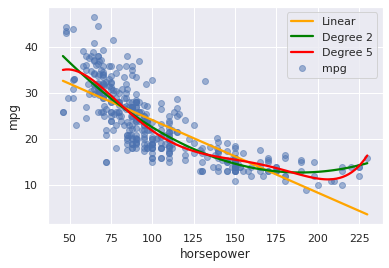

In [30]:
plt.scatter(data=auto, x="horsepower", y="mpg",alpha=0.5) 
sns.regplot(data=auto, x="horsepower", y="mpg", ci=None, label='Linear', scatter=False, color='orange')
sns.regplot(data=auto, x="horsepower", y="mpg", ci=None, label='Degree 2', order=2, scatter=False, color='green')
sns.regplot(data=auto, x="horsepower", y="mpg", ci=None, label='Degree 5', order=5, scatter=False, color='red')
plt.legend()
plt.show()

5乗の回帰曲線は不自然に曲がっており、データへの適合度が上がったかどうか不明。詳しくは7章で


### 3.3.3 問題点

データセットに線形回帰モデルを適用すると問題が起こることがある。代表的なものは

#### 1 非線形関係によるもの
残差をプロットすることで識別する。説明変数に対して非線形変換をすることで対応する。

#### 2 誤差の相関関係
誤差項の間に相関関係があると真の標準誤差を過小に評価してしまう。結果、信頼区間や予測区間が狭くなったり、p値を低く計算してしまう。隣り合うデータに正の相関がある誤差を持つ時系列データで発生することが多い。

時系列データ以外にもサンプルの選び方が適切でないと誤差に相関が発生することがある。

#### 3 誤差の一定でない分散
例えば、 $X$ の値が大きほど分散が大きくなることがある。凹関数を使って　$Y$ を変換して対処する。

#### 4 外れ値
外れ値は最小二乗推定量にはあまり影響を及ぼさないが、RSEや$R^2$などには影響を与える。

外れ値を見つけるには残差プロットが有効。どこからを外れ値とするかは残差をその標準偏差の推定量で割ったスチューデント化残差をプロットすることで見つける事ができる。

#### 5 高レバレッジ値
$x_i$ が　他の $x$から離れている場合、 $x_i$ は高いレバレッジを持つ。

高レバレッジ値を削除すると、最小二乗推定量に与える影響が大きい。

判定にはレバレッジ統計量を使う。単回帰の場合には

$$h_i = \frac{1}{n} + \frac{(x_i - \bar{x})^2}{\sum_{i'=1}^n(x_{i'} - \bar{x})^2}$$

レバレッジ統計量が $(p+1)/n$ を大きく超える場合、そのデータが高いレバレッジを持っていることが考えられる。

#### 6 共線性
2つの説明変数が密接に関係している状態を指す。

このような場合には、個々の変数の効果を分離することが困難になったり、最小二乗推定量の精度が低下したりする。


## 3.4 マーケティング・プラン

## 3.5 線形回帰とk近傍法の比較
